In [1]:
%load_ext autoreload
%autoreload

from pyDOE import *
from pandas import read_csv,DataFrame
import numpy as np
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
from lib_for_paper import *
from pandas.io import wb


data_path="data/"
figures_path="figures_paper_python_July1/"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

co2_by_sector=read_csv(data_path+"enerdata_emissions_world.csv")
elec_comit=read_csv(data_path+"Future_Power_Sector_Emissions_Committed_ton_CO2.csv")
un_pop=read_csv(data_path+"Total_population_both_sexes_thousands.csv")

scenario_file=read_csv(data_path+"scenarios.csv")

myyears=range(2013,2051)
hist_years=range(1990,2014)

%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
def get_wb_data(data):
    aa = wb.download(indicator=data,start=1990,end=2013,country='all').reset_index()
    out = aa.ix[aa.country=="World",data]
    out.index=range(2013,1989,-1)
    out = out.sort_index(ascending=True)
    return out

In [3]:
hist_emi = get_wb_data("EN.ATM.CO2E.KT")

In [4]:
carb_intens_hist = 1000*get_wb_data("EN.ATM.CO2E.PP.GD.KD")

In [5]:
hist_emi[2012]=34500000
hist_emi[2013]=36000000
hist_emi[2011]=(hist_emi[2010]+hist_emi[2012])/2

In [6]:
global_emissions_2013_TCO2 = 10**(3)*hist_emi[2013]

In [7]:
hist_gdp = get_wb_data('NY.GDP.MKTP.PP.KD')
GDP_PPP_const_dol_2013 = hist_gdp[2013]

In [8]:
co2_missing=global_emissions_2013_TCO2-10**9*co2_by_sector['2013'].sum()
co2_processes = 2/3*co2_missing
scale_fact = global_emissions_2013_TCO2/(10**9*co2_by_sector['2013'].sum()+co2_processes)
co2_tertiary=10**9*co2_by_sector.loc[2,'2013']*scale_fact
co2_industry=(10**9*co2_by_sector.loc[1,'2013']+co2_processes)*scale_fact
co2_ener=10**9*co2_by_sector.loc[0,'2013']*scale_fact
co2_transport=10**9*co2_by_sector.loc[3,'2013']*scale_fact

#pop 2013
pop_ref=1000*(un_pop.ix[un_pop['year']==2013,'population'].values[0])

# per capita GDP 2013
gdp_pc_ref=GDP_PPP_const_dol_2013/pop_ref

# carbon intensity 2013 (tonCO2/dol)
carb_int_ref=10**(6)*global_emissions_2013_TCO2/GDP_PPP_const_dol_2013

kintref=3.4

In [9]:
carb_int_ref

358.86289437363308

In [10]:
ranges=read_csv(data_path+"scenarios_ranges.csv")
ranges1=ranges.drop(ranges.index[ranges['variable']=='budget'])
scenarios=create_scenarios(ranges1,4000)
scenarios["eleclife"] = np.round(scenarios["eleclife"],1)

In [11]:
ranges

,variable,min,max
0,budget,550.0000,1300.0000
1,induslife,10.0000,50.0000
2,tertlife,20.0000,100.0000
3,transplife,5.0000,30.0000
4,GDPgrate,0.0000,0.0400
5,poprate,0.0047,0.0114
6,eleclife,20.0000,60.0000
7,kintrate,-0.0050,0.0200


In [12]:
if os.path.isfile("elec_scenars_01.csv"):
    elec_scenars = read_csv("elec_scenars_01.csv")
    elec_scenars.index = elec_scenars.eleclife
    elec_scenars = elec_scenars.drop("eleclife",axis=1)
else:
    elec_scenars = create_elec_comit_table(elec_comit,np.round(np.arange(20,60,0.1),1),myyears)

In [13]:
select50 = scenario_file['years']<=2050

rcp26 = 44/12*scenario_file.ix[select50,'RCP 26']
rcp45 = 44/12*scenario_file.ix[select50,'RCP 45']
rcp6 = 44/12*scenario_file.ix[select50,'RCP 6']
rcp85 = 44/12*scenario_file.ix[select50,'RCP 85']
rcp_years = scenario_file.ix[select50,'years']

In [14]:
from scipy.interpolate import interp1d

rcp26full=interp1d(scenario_file["years"], scenario_file["RCP 26"])
rcp45full=interp1d(scenario_file["years"], scenario_file["RCP 45"])
rcp6full=interp1d(scenario_file["years"], scenario_file["RCP 6"])
rcp85full=interp1d(scenario_file["years"], scenario_file["RCP 85"])

In [15]:
print(44/12*sum(rcp26full(range(2013,2051))))
print(44/12*sum(rcp45full(range(2013,2051))))
print(44/12*sum(rcp85full(range(2013,2051))))

913.863133333
1479.2745
2032.4293


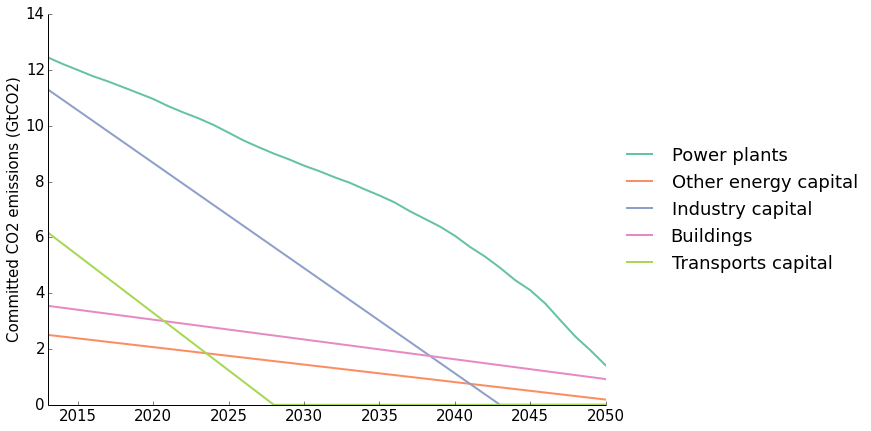

In [16]:
tertlife=50
transplife=15
induslife=30
eleclife=40

elec_comit_scenar=get_elec_comit(eleclife,myyears,elec_comit)
co2_energy_not_power=co2_ener-elec_comit_scenar[0]
enernotpower_com=calc_comit_e(eleclife,co2_energy_not_power,myyears)
industry_com=calc_comit_e(induslife,co2_industry,myyears)
tertiary_com=calc_comit_e(tertlife,co2_tertiary,myyears)
transport_com=calc_comit_e(transplife,co2_transport,myyears)

thecolors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']

font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

plt.plot(myyears,10**(-9)*elec_comit_scenar,color=thecolors[0],linewidth=2,label="Power plants")
plt.plot(myyears,10**(-9)*enernotpower_com,color=thecolors[1],linewidth=2,label="Other energy capital")
plt.plot(myyears,10**(-9)*industry_com,color=thecolors[2],linewidth=2,label="Industry capital")
plt.plot(myyears,10**(-9)*tertiary_com,color=thecolors[3],linewidth=2,label="Buildings")
plt.plot(myyears,10**(-9)*transport_com,color=thecolors[4],linewidth=2,label="Transports capital")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel("Committed CO2 emissions (GtCO2)")
ax.set_xlim([2013,2050])

plt.savefig(figures_path+"committed.png",dpi=300,bbox_inches="tight")

In [17]:
traj = rcp26full(range(2013,2100))
sum(traj[traj<0])/25

-0.67059199999999974

In [18]:
for neg in [0,-10,-20]:
    totnegemissions = neg*25
    by2050 = sum(rcp26full(range(2013,2051)))-(totnegemissions-sum(traj[traj<0]))*(2050-2013)/(2075-2013)
    print(by2050*44/12)

877.178866667
1424.22187742
1971.26488817


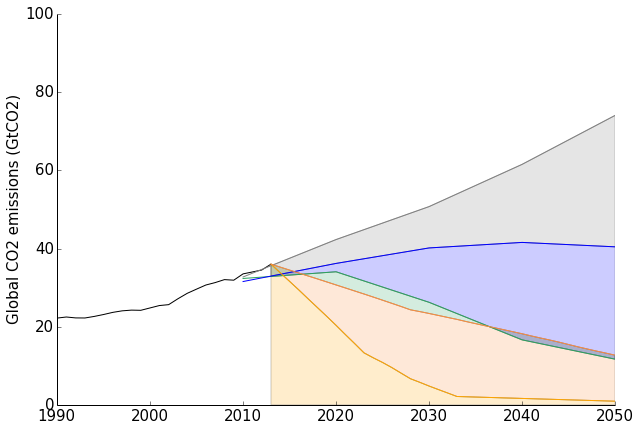

In [19]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

comitted_low = 10**(-9)*36*10**(9)/global_emissions_2013_TCO2*calc_all_comit(0,0,20,myyears,elec_scenars,co2_industry,\
                                                                             co2_tertiary,co2_transport,\
                                         10,50,15,2013,co2_ener,carb_int_ref,gdp_pc_ref,0.0081,pop_ref)
comitted_high = 10**(-9)*36*10**(9)/global_emissions_2013_TCO2*calc_all_comit(0,0,59.9,myyears,elec_scenars,co2_industry,co2_tertiary,co2_transport,
                                         50,50,15,2013,co2_ener,carb_int_ref,gdp_pc_ref,0.0081,pop_ref)

plt.plot(hist_years,10**(-6)*hist_emi,"black")
plt.plot(rcp_years[rcp_years>=2010],rcp26[rcp_years>=2010],color="#2ca25f")
plt.plot(rcp_years[rcp_years>=2010],rcp45[rcp_years>=2010],color="blue")
#plt.plot(rcp_years,rcp6,color="red")
plt.plot(rcp_years[rcp_years>=2010],rcp85[rcp_years>=2010],color="grey")
#plt.plot(myyears,10**(-15)*calc_bau_emissions(0.02,0,carb_int_correct,myyears,gdp_pc_ref,0.0081,pop_ref),color="black",linestyle='--')
plt.plot(myyears,comitted_low,color='orange')
plt.plot(myyears,comitted_high,color='#fd8d3c')
ax.set_ylim([0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel("Global CO2 emissions (GtCO2)")

ax.fill_between(myyears,0,comitted_low ,facecolor="orange",alpha=0.2, interpolate=True)
ax.fill_between(myyears,comitted_low,comitted_high ,facecolor="#fd8d3c",alpha=0.2, interpolate=True)
ax.fill_between(myyears,comitted_high,44/12*rcp26full(myyears) ,facecolor="#2ca25f",alpha=0.2, interpolate=True)
ax.fill_between(myyears,44/12*rcp26full(myyears),44/12*rcp45full(myyears) ,facecolor="blue",alpha=0.2, interpolate=True)
ax.fill_between(myyears,44/12*rcp45full(myyears),44/12*rcp85full(myyears) ,facecolor="grey",alpha=0.2, interpolate=True)

plt.savefig(figures_path+"emissions.eps",format='eps',bbox_inches="tight")
plt.savefig(figures_path+"emissions.png",format='png',dpi=300,bbox_inches="tight")

In [20]:
sum(comitted_high)

888.32136607870552

In [21]:
sum(comitted_low)

364.92647811274884

# first analysis

In [22]:
IC_growth=0
ini_year=2013
budget=915
poprate=0.008
tertlife=50
transplife=15
induslife=47
eleclife=52
GDPgrate=0.03
kintrate=0.01

carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,gdp_pc_ref,
                                                         poprate,pop_ref,eleclife,myyears,elec_scenars,co2_industry,
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                   ini_year,co2_ener,kintrate,kintref)

print(carb_intens_new_K)
print(sum(total_comit))
print(k_over_g_av)

ValueError: need more than 4 values to unpack

In [ ]:
for induslife in [10,30,50]:
    for eleclife in [20,40,60]:
        carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
        print(sum(total_comit))

In [ ]:
kintrate=0.01
for GDPgrate in [0.01,0.02,0.03]:
    eleclife=20
    induslife=10
    carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    print(carb_intens_new_K,k_over_g_av)

In [ ]:
sum(44/12*rcp26full(myyears))

In [ ]:
sum(44/12*rcp45full(myyears))

In [ ]:
out26=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_K','carb_intens','remain_e'])

IC_growth=0
ini_year=2013
budget=sum(44/12*rcp26full(myyears))
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife,kintrate]=scenarios.loc[scenar,:].values
    carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    
    out26.loc[len(out26.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_K,carb_intens,remain_e]

out26=out26.astype(float)

In [ ]:
out45=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_K','carb_intens','remain_e'])

IC_growth=0
ini_year=2013
budget=sum(44/12*rcp45full(myyears))
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife,kintrate]=scenarios.loc[scenar,:].values
    carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    
    out45.loc[len(out45.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_K,carb_intens,remain_e]

out45=out45.astype(float)

In [ ]:
out26.ix[:,["carb_intens_new_K","carb_intens"]].describe()

In [ ]:
plt.scatter(out26.carb_intens,out26.carb_intens_new_K)

In [ ]:
out26.ix[out26.carb_intens_new_K>10,'carb_intens'].describe()

In [ ]:
plt.scatter(out45.carb_intens,out45.carb_intens_new_K)

In [ ]:
out45[["carb_intens_new_K","carb_intens"]].describe()

In [ ]:
plt.scatter(out45["GDPgrate"],out45["carb_intens_new_K"],marker="x",s=40)

In [ ]:
select=out45["GDPgrate"]>0.03
out45.ix[select,"carb_intens_new_K"].mean()

In [ ]:
select=(out45["GDPgrate"]<0.03)&(out45["GDPgrate"]>0.01)
out45.ix[select,"carb_intens_new_K"].mean()

In [ ]:
np.percentile(out26['carb_intens_new_K'],[5,95])

In [ ]:
np.percentile(out45['carb_intens_new_K'],[5,95])

Decrease compared to today:

In [ ]:
0.38/np.percentile(out26['carb_intens_new_K'],[5,95])

In [ ]:
formula="carb_intens_new_K ~ tertlife + induslife + transplife + GDPgrate + poprate +eleclife+ kintrate"
olsmodel=ols(formula,data=out26).fit()
table=anova_lm(olsmodel)
table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()

In [ ]:
table.ix["tertlife","title"] = 'Lifetime of buildings'
table.ix["induslife","title"] = 'Lifetime of industry capital'
table.ix["transplife","title"] = 'Lifetime of transport capital'
table.ix["GDPgrate","title"] = 'GDP growth rate'
table.ix["poprate","title"] = 'Population growth rate'
table.ix["eleclife","title"] = 'Lifetime of energy capital\n(mostly power plants)'
table.ix["Residual","title"] = 'Combination of parameters'
table.ix["kintrate","title"] = 'Capital intensity of GDP'

table.ix["tertlife","colors"] = '#8dd3c7'
table.ix["induslife","colors"] = '#ffffb3'
table.ix["transplife","colors"] = '#bebada'
table.ix["GDPgrate","colors"] = '#fb8072'
table.ix["poprate","colors"] = '#80b1d3'
table.ix["eleclife","colors"] = '#fdb462'
table.ix["Residual","colors"] = '#b3de69'

In [ ]:
table

In [ ]:
olsmodel2=ols(formula,data=out45).fit()
table2=anova_lm(olsmodel2)
table2['sum_sq_pc']=table2['sum_sq']/table2['sum_sq'].sum()
table2.ix["tertlife","title"] = 'Lifetime of buildings'
table2.ix["induslife","title"] = 'Lifetime of industry capital'
table2.ix["transplife","title"] = 'Lifetime of transport capital'
table2.ix["GDPgrate","title"] = 'GDP growth rate'
table2.ix["poprate","title"] = 'Population growth rate'
table2.ix["eleclife","title"] = 'Lifetime of energy capital\n(mostly power plants)'
table2.ix["Residual","title"] = 'Combination of parameters'
table2.ix["kintrate","title"] = 'Capital intensity of GDP'

table2.ix["tertlife","colors"] = '#8dd3c7'
table2.ix["induslife","colors"] = '#ffffb3'
table2.ix["transplife","colors"] = '#bebada'
table2.ix["GDPgrate","colors"] = '#fb8072'
table2.ix["poprate","colors"] = '#80b1d3'
table2.ix["eleclife","colors"] = '#fdb462'
table2.ix["Residual","colors"] = '#b3de69'

In [ ]:
table2

In [ ]:
tot_26 = 44/12*sum(rcp26full(range(2013,2100)))
tot_45 = 44/12*sum(rcp45full(range(2013,2100)))

In [ ]:
two_deg_50pc = 1100
three_deg_66pc = 2280

In [ ]:
sum(44/12*rcp26full(myyears))*two_deg_50pc/tot_26

In [ ]:
sum(44/12*rcp45full(myyears))*three_deg_66pc/tot_45

In [ ]:
out2C_50=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_K','carb_intens','remain_e'])

IC_growth=0
ini_year=2013
budget=1200
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife,kintrate]=scenarios.loc[scenar,:].values
    carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    out2C_50.loc[len(out2C_50.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_K,carb_intens,remain_e]

out2C_50=out2C_50.astype(float)

In [ ]:
out3C_50=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_K','remain_e'])

IC_growth=0
ini_year=2013
budget=1600
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife,kintrate]=scenarios.loc[scenar,:].values
    carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    out3C_50.loc[len(out3C_50.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_K,remain_e]

out3C_50=out3C_50.astype(float)

In [ ]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

plt.hist(out26['carb_intens_new_K'],bins=100,alpha=0.1,normed=1,color="#000F00")
density = gaussian_kde(out26['carb_intens_new_K'])
xs = np.linspace(out26['carb_intens_new_K'].min()-10,out26['carb_intens_new_K'].max(),100)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color="#000F00",label="2C (>66%) - RCP2.6")
plt.xlabel('CO2 intensity of new capital investment (gCO2/2011 usd ppp)\nbetween 2013 and 2050')

plt.hist(out2C_50['carb_intens_new_K'],bins=100,alpha=0.1,normed=1,color="#005C00")
density3 = gaussian_kde(out2C_50['carb_intens_new_K'])
xs3 = np.linspace(out2C_50['carb_intens_new_K'].min()-10,out2C_50['carb_intens_new_K'].max(),100)
density3.covariance_factor = lambda : .25
density3._compute_covariance()
plt.plot(xs3,density3(xs3),linewidth=2,color="#009900",label="2C (>50%)")

plt.hist(out45['carb_intens_new_K'],bins=100,alpha=0.1,normed=1,color="#009900")
density2 = gaussian_kde(out45['carb_intens_new_K'])
xs2 = np.linspace(out45['carb_intens_new_K'].min()-10,100,200)
density2.covariance_factor = lambda : .25
density2._compute_covariance()
plt.plot(xs2,density2(xs2),linewidth=2,color="#009900",label="3C (>66%) - RCP4.5")

plt.hist(out3C_50['carb_intens_new_K'],bins=100,alpha=0.1,normed=1,color="#66C266")
density4 = gaussian_kde(out3C_50['carb_intens_new_K'])
xs4 = np.linspace(out3C_50['carb_intens_new_K'].min()-10,out3C_50['carb_intens_new_K'].max(),100)
density4.covariance_factor = lambda : .25
density4._compute_covariance()
plt.plot(xs4,density4(xs4),linewidth=2,color="#009900",label="3C (>50%)")

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.legend(loc='upper right',frameon=False)
plt.savefig(figures_path+"hist.eps",format='eps')
plt.savefig(figures_path+"hist.png",format='png',dpi=300)

In [ ]:
from lib_for_prim import *

In [ ]:
experiments=out45[['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife','kintrate']]
outcomes=out45[['carb_intens_new_K']]
outcomes['un']=0+outcomes['carb_intens_new_K']>60
outcomes['deux']=0+outcomes['carb_intens_new_K']>80

In [ ]:
experiments2=out45[['tertlife', 'induslife', 'transplife', 'poprate','eleclife','kintrate']]
outcomes['trois']=0+(outcomes['carb_intens_new_K']>60)&(out26['GDPgrate']>0.02)

In [ ]:
forprim=format_data(outcomes,experiments,"un")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [ ]:
box.inspect(20)

In [ ]:
out45.ix[out45['GDPgrate']>0.02,'carb_intens_new_K'].min()

# Second analysis

In [ ]:
def run_scenarios(outall,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,co2_industry,co2_tertiary,\
                  co2_transport,co2_ener,ini_year,budget,IC_growth=0):
    outy=DataFrame(columns=list(scenarios.columns)+['ini_year','budget','carb_intens_new_K','carb_intens','remain_e','total_comit'])
    for scenar in scenarios.index:
        [induslife,tertlife,transplife, GDPgrate, poprate,eleclife,kintrate]=scenarios.loc[scenar,:].values
        carb_intens_new_K,carb_intens,remain_e,total_comit,k_over_g_av=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
        outy.loc[len(outy.index)]=list(scenarios.loc[scenar,:].values)+[ini_year,budget,carb_intens_new_K,carb_intens,remain_e,sum(total_comit)]
    outall=outall.append(outy.astype(float),ignore_index=True)
    return outall

In [25]:
csvname = "all_years_rcp26_june30.csv"
if os.path.isfile(csvname):
    outall26=read_csv(csvname)
else:
    outall26=DataFrame()
    for ini_year in [2013,2015,2017,2019,2021]:
        outall26 = run_scenarios(outall26,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,ini_year,44/12*sum(rcp26full(myyears)))
    outall26.to_csv(csvname)

In [23]:
csvname = "all_years_rcp45_june30.csv"
if os.path.isfile(csvname):
    outall45=read_csv(csvname)
else:
    outall45=DataFrame()
    for ini_year in [2013,2015,2017,2019,2021]:
        outall45 = run_scenarios(outall45,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,ini_year,44/12*sum(rcp45full(myyears)))
    outall45.to_csv(csvname)

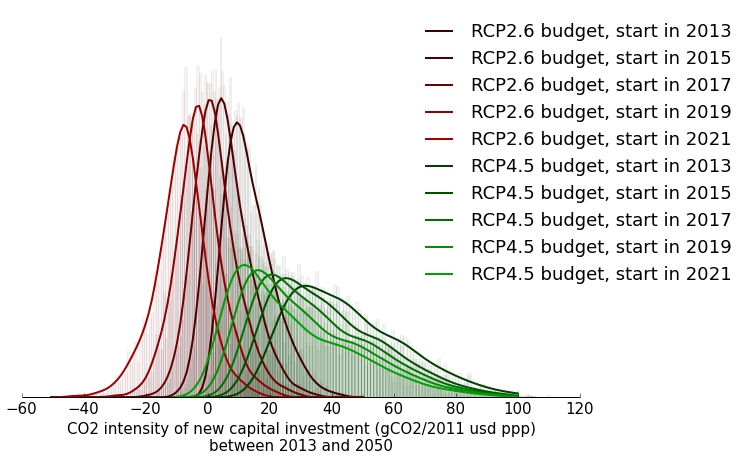

In [26]:
date_list = [2013,2015,2017,2019,2021]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

color_list2=["#004000","#005000","#007000","#009000","#00A000","#00C000","#00E000"]
color_list1=["#400000","#500000","#700000","#900000","#A00000","#C00000","#E00000"]

for ini_year in date_list:
    thecolor=color_list1[date_list.index(ini_year)]
    data=outall26.ix[outall26['ini_year']==ini_year,'carb_intens_new_K']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall26['carb_intens_new_K'].min(),outall26['carb_intens_new_K'].max(),100)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="RCP2.6 budget, start in {}".format(ini_year)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)
    
for ini_year in date_list:
    thecolor=color_list2[date_list.index(ini_year)]
    data=outall45.ix[outall45['ini_year']==ini_year,'carb_intens_new_K']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall45['carb_intens_new_K'].min()-10,100,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="RCP4.5 budget, start in {}".format(ini_year)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(bbox_to_anchor=[0.8,0.5,0.5,0.5],frameon=False)
plt.xlabel('CO2 intensity of new capital investment (gCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.savefig(figures_path+"hist_diff_ini_year.eps",format='eps')
plt.savefig(figures_path+"hist_diff_ini_year.png",format='png',dpi=300)

In [27]:
csvname = "all_budgets_june30.csv"
if os.path.isfile(csvname):
    outallb=read_csv(csvname)
else:
    outallb=DataFrame()
    for budget in [500,600,700,800,900,1000,1100,1200,1300,1400,1500]:
        outallb = run_scenarios(outallb,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,2013,budget)
    outallb.to_csv(csvname)

In [28]:
csvname = "budgets_real_neg_emissions_june30.csv"
if os.path.isfile(csvname):
    outneg=read_csv(csvname)
else:
    outneg=DataFrame()
    for neg in [0,-5,-10,-15,-20]:
        totnegemissions = neg*25
        by2050 = sum(rcp26full(range(2013,2051)))-(totnegemissions-sum(traj[traj<0]))*(2050-2013)/(2075-2013)
        budget = by2050*44/12
        outneg = run_scenarios(outneg,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,2013,budget)
        outneg.ix[outneg["budget"]==budget,"negative_rate"] = neg
    outneg.to_csv(csvname)

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

color_list=["#000040","#000070","#000090","#0000C0","#0000E0"]
neg_list = [0,-5,-10,-15,-20]

for neg in neg_list:
    thecolor=color_list[neg_list.index(neg)]
    data=outneg.ix[outneg['negative_rate']==neg,'carb_intens_new_K']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outneg['carb_intens_new_K'].min()-10,200,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="{} GtCO2/yr after 2075".format(neg)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(loc='upper right',frameon=False)
plt.xlabel('CO2 intensity of new capital investment (gCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.savefig(figures_path+"hist_NET.eps",format='eps')
plt.savefig(figures_path+"hist_NET.png",dpi=300)

In [29]:
from lib_for_prim import *
experiments=outneg[['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife',\
                    'negative_rate','kintrate']]
outcomes=outneg[['carb_intens_new_K']]

In [30]:
outcomes.describe()

,carb_intens_new_K
count,20000.000000
mean,41.941863
std,28.712405
min,-3.709974
25%,19.992196
50%,36.393651
75%,57.618085
max,183.821922


C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


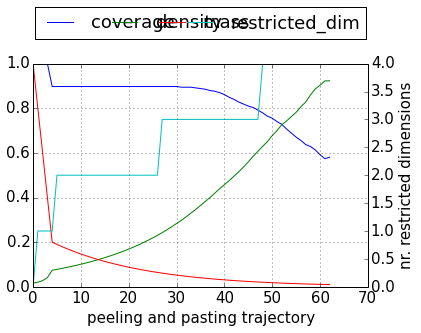

In [32]:
outcomes['un']=0+outcomes['carb_intens_new_K']>120
forprim=format_data(outcomes,experiments,"un")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [33]:
box.inspect(50)

coverage    0.755287
density     0.677507
mass        0.018450
mean        0.677507
res dim     4.000000
Name: 50, dtype: float64

                  box 50                          
                     min        max      qp values
GDPgrate        0.000002   0.008493  9.861244e-116
negative_rate -20.000000 -17.500000  4.324790e-113
kintrate       -0.004997   0.006931   1.206119e-41
poprate         0.004702   0.011114   1.424735e-01



In [34]:
experiments.describe()

,tertlife,induslife,transplife,GDPgrate,poprate,eleclife,negative_rate,kintrate
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,59.999935,30.000018,17.499942,0.020000,0.008050,40.000000,-10.000000,0.007500
std,23.094687,11.547297,7.217102,0.011547,0.001934,11.547366,7.071245,0.007217
min,20.003328,10.009207,5.004718,0.000002,0.004702,20.000000,-20.000000,-0.004997
25%,39.997406,20.001212,11.250269,0.010003,0.006375,30.000000,-15.000000,0.001249
50%,60.000681,30.003328,17.498025,0.019997,0.008050,40.000000,-10.000000,0.007503
75%,79.997071,39.993805,23.746842,0.029997,0.009724,50.000000,-5.000000,0.013750
max,99.992117,49.997120,29.999861,0.039992,0.011399,60.000000,0.000000,0.019998


In [88]:
experiments2=outneg.ix[outneg['negative_rate']==0,['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate',\
                                                  'eleclife']]
outcomes2=outneg.ix[outneg['negative_rate']==0,['carb_intens']]

In [89]:
outcomes2.describe()

,carb_intens
count,3000.000000
mean,135.818967
std,33.551541
min,78.880767
25%,106.269183
50%,132.356247
75%,162.440324
max,211.430438


In [105]:
np.percentile(outcomes2,[50,75,90])

array([ 43.26814643,  64.176452  ,  87.49141551])

In [106]:
experiments2.ix[outcomes2['carb_intens_new_GDP']>150,:]

,tertlife,induslife,transplife,GDPgrate,poprate,eleclife
6576,45.220983,16.458404,5.531988,0.001025,0.005035,22.1


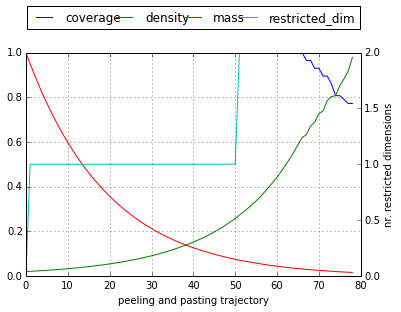

In [96]:
outcomes2['un']=0+outcomes2['carb_intens']>200
forprim=format_data(outcomes2,experiments2,"un")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [97]:
box.inspect(70)

coverage    0.929825
density     0.726027
mass        0.024333
mean        0.726027
res dim     2.000000
Name: 70, dtype: float64

            box 70                        
               min       max     qp values
GDPgrate  0.000002  0.002828  6.665982e-52
poprate   0.004701  0.007007  5.516140e-16



In [64]:
experiments3=outneg.ix[outneg['negative_rate']==-5,['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate',\
                                                  'eleclife']]
outcomes3=outneg.ix[outneg['negative_rate']==-5,['carb_intens_new_GDP']]

In [65]:
sum(outcomes3['carb_intens_new_GDP']>150)/len(outcomes3['carb_intens_new_GDP']>150)

0.185

In [66]:
outcomes3.describe()

,carb_intens_new_GDP
count,10000.000000
mean,108.511110
std,41.487737
min,29.593709
25%,74.983140
50%,101.746600
75%,137.670037
max,241.058460


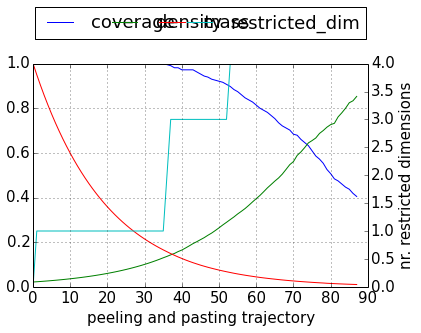

In [67]:
outcomes3['un']=0+outcomes3['carb_intens_new_GDP']>200
forprim=format_data(outcomes3,experiments3,"un")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [68]:
box.inspect(70)

coverage    0.683721
density     0.561069
mass        0.026200
mean        0.561069
res dim     4.000000
Name: 70, dtype: float64

              box 70                          
                 min        max      qp values
GDPgrate    0.000001   0.003562  4.860940e-109
eleclife   20.000000  41.250000   3.773414e-13
poprate     0.004701   0.009658   1.860334e-04
induslife  10.000974  39.706743   1.994698e-04



In [324]:
from pandas import cut,get_dummies

In [325]:
out900 = outallb.ix[outallb.budget==900,:]
out900["mean_lifetime"] = (out900.eleclife+out900.induslife)/2

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [326]:
mean_lifetime = get_dummies(cut(out900.mean_lifetime,[10,20,30,40,50,60]))

In [327]:
mycolors = ["#1a9641","#a6d96a","#ffffbf","#fdae61","#d7191c"]
groups = list(mean_lifetime.columns)

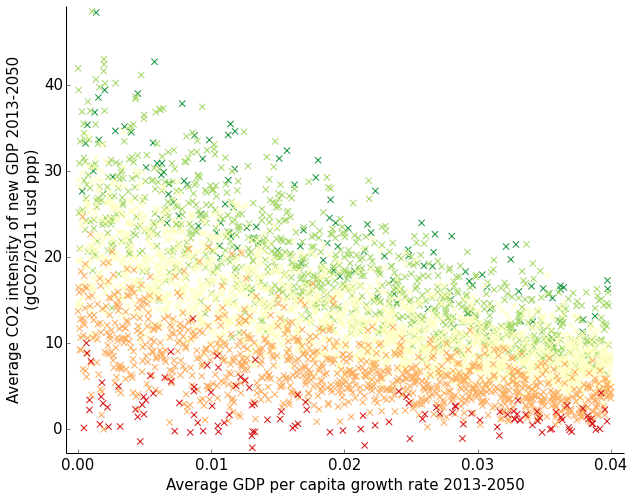

In [328]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
fig = plt.figure(figsize=(10,8))
ax1=plt.subplot(111)

for col in groups:
    select = mean_lifetime[col].values.astype(bool)
    ax1.scatter(out900.ix[select,"GDPgrate"],out900.ix[select,"carb_intens_new_K"],c=mycolors[groups.index(col)],
                marker="x",s=40)


ax1.margins(0.01)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.ylabel("Average CO2 intensity of new GDP 2013-2050\n(gCO2/2011 usd ppp)")
plt.xlabel("Average GDP per capita growth rate 2013-2050")
#plt.savefig(figures_path+"carb_intens_explained.eps",format='eps',bbox_inches="tight")
#plt.savefig(figures_path+"carb_intens_explained_option1",format='png',bbox_inches="tight")

In [329]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

cMap = []
for value, colour in zip([0,1,2,3,4],["#1a9641","#a6d96a","#ffffbf","#fdae61","#d7191c"]):
    cMap.append((value/4, colour))
colorMap2 = LinearSegmentedColormap.from_list("custom", cMap)

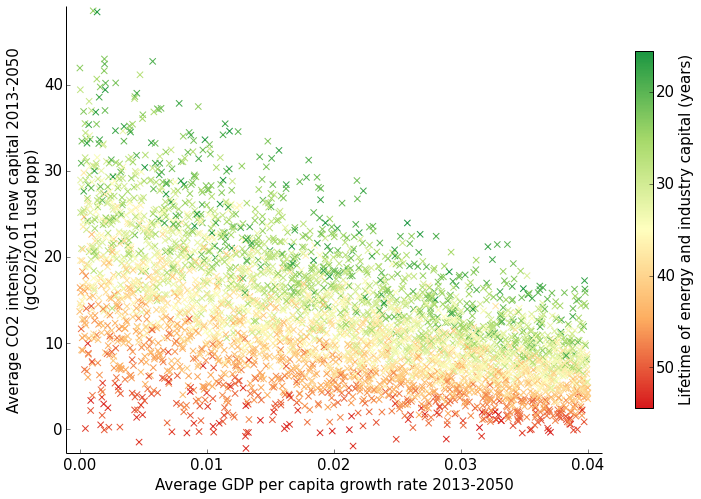

In [330]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
fig = plt.figure(figsize=(12,8))
ax1=plt.subplot(111)
#l = ax1.scatter(out26["GDPgrate"],out26["carb_intens_new_GDP"],c=out26["eleclife"],\
#                marker="o",cmap='Greens',alpha=0.5,edgecolor='grey',s=40)
l = ax1.scatter(out900["GDPgrate"],out900["carb_intens_new_K"],c=(out900.eleclife+out900.induslife)/2,
                marker="x",s=40,cmap=colorMap2)
#cb = fig.colorbar(l,shrink=0.8)
cb = fig.colorbar(l,shrink=0.8,ticks=[20,30,40,50,60])
cb.ax.invert_yaxis()
#cb.ax.set_yticklabels([str(i) for i in range(20,70,10)])# vertically oriented colorbar
cb.set_label("Lifetime of energy and industry capital (years)")


#ax1.scatter(out45["GDPgrate"],out45["carb_intens_new_GDP"],color="red",marker="+")
ax1.margins(0.01)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.ylabel("Average CO2 intensity of new capital 2013-2050\n(gCO2/2011 usd ppp)")
plt.xlabel("Average GDP per capita growth rate 2013-2050")
plt.savefig(figures_path+"carb_intens_explained.eps",format='eps',bbox_inches="tight")
plt.savefig(figures_path+"carb_intens_explained_option1.png",format='png',bbox_inches="tight",dpi=300)

In [332]:
anova_all=DataFrame(columns=['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife','kintrate'])
for budget in outallb.budget.unique():
    out = outallb.ix[outallb.budget==budget,:]

    formula="carb_intens_new_K ~ tertlife + induslife + transplife + GDPgrate + poprate +eleclife+kintrate"
    olsmodel=ols(formula,data=out).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=100*table['sum_sq']/table['sum_sq'].sum()    
    tablet=table.transpose()
    inter=tablet.loc[['sum_sq_pc']]
    inter.index=[budget]
    anova_all=anova_all.append(inter)

In [336]:
anova_all.rename(columns={"tertlife":'Lifetime of buildings',"induslife":'Lifetime of industry capital',"transplife":\
                         'Lifetime of transport capital',"GDPgrate":'GDP growth rate',"poprate":'Population growth rate',\
                         "eleclife":'Lifetime of energy capital\n(mostly power plants)',"Residual":\
                          'Combination of parameters',"kintrate":"Capital intensity of GDP"},inplace=True)

In [337]:
anova_all[800:1600]

,GDP growth rate,Combination of parameters,Lifetime of energy capital (mostly power plants),Lifetime of industry capital,Capital intensity of GDP,Population growth rate,Lifetime of buildings,Lifetime of transport capital
800,12.006527,11.360515,45.509984,22.350135,3.840981,0.421324,1.759569,2.750966
900,31.365203,8.410939,31.221563,15.320448,9.465560,1.039257,1.229266,1.947765
1000,47.629184,6.467337,19.002902,9.315638,14.047636,1.542914,0.764362,1.230027
1100,57.996164,5.495914,11.107191,5.438563,16.896601,1.856201,0.458328,0.751039
1200,64.025601,5.088697,6.451756,3.154463,18.511244,2.033835,0.274619,0.459784
1300,67.473473,4.959912,3.747843,1.829066,19.406645,2.132396,0.165794,0.284872
1400,69.456392,4.960827,2.162704,1.052936,19.901491,2.186907,0.100489,0.178253
1500,70.603368,5.019623,1.222442,0.593220,20.172095,2.216748,0.060602,0.111901


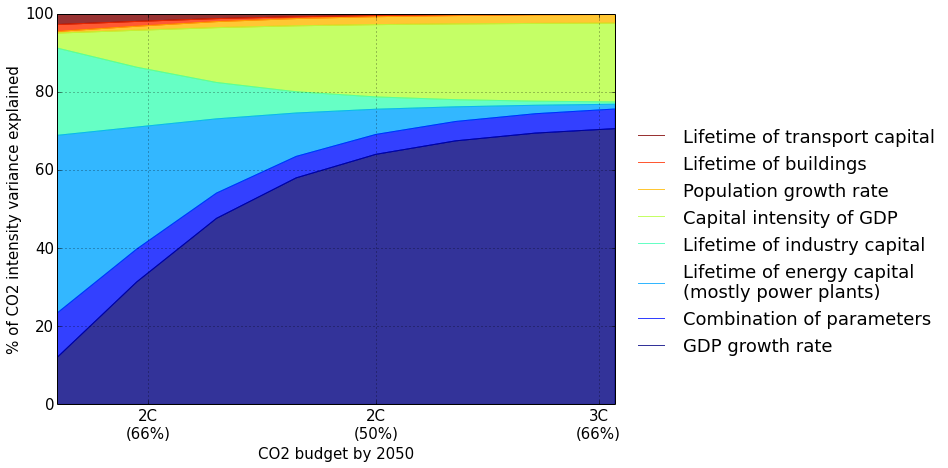

In [338]:
f1 = plt.figure(figsize=(10,7))
anova_all[800:1500].plot(ylim=(0,100),sort_columns=False,kind='area',colormap="jet",ax=f1.gca(),alpha=0.8)
#.legend(bbox_to_anchor=(1.6, 0.75),frameon=False)
ax=f1.gca()
#plt.xticks(anova_all.index,np.round(2.2/1000*12/44*(np.array(anova_all.index)+1900),2))
handles, labels = ax.get_legend_handles_labels()
#l = ax.get_legend()
ax.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.6, 0.75),frameon=False)
plt.ylabel('% of CO2 intensity variance explained')
ax.set_xlabel('CO2 budget by 2050')

ax.set_xticks(np.array([sum(44/12*rcp26full(myyears)),1200,\
                        sum(44/12*rcp45full(myyears))]))

ax.set_xticklabels(['2C\n(66%)','2C\n(50%)',\
                        '3C\n(66%)'])

plt.savefig(figures_path+"anova_all_budgets.eps",format='eps',bbox_inches="tight")
plt.savefig(figures_path+"anova_all_budgets.png",format='png',dpi=300,bbox_inches="tight")